In [ ]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid


Global Variable

In [2]:
# Path to all data
DATA_PATH = "YOUR PATH"

# File path line length images for later sorting
BASE_LEN = 89 
END_IMG_LEN = 4
END_MASK_LEN = 9

# img size
IMG_SIZE = 512

# Data

## Creating a DataFrame

In [ ]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

In [ ]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Final dataframe

In [ ]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

## Data Distribution

Distribution of positive/negative diagnosis

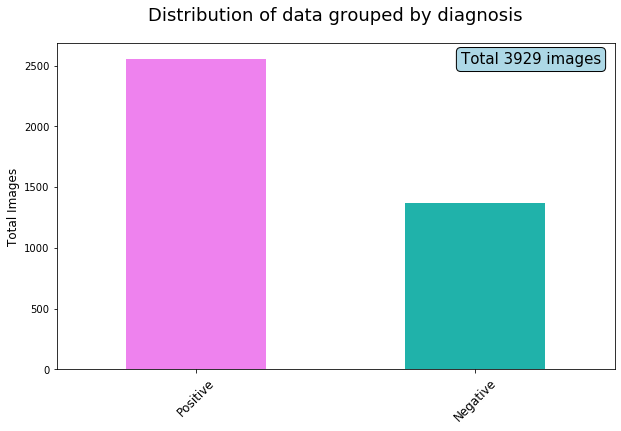

In [6]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

Distribution of positive/negative diagnosis between each patient

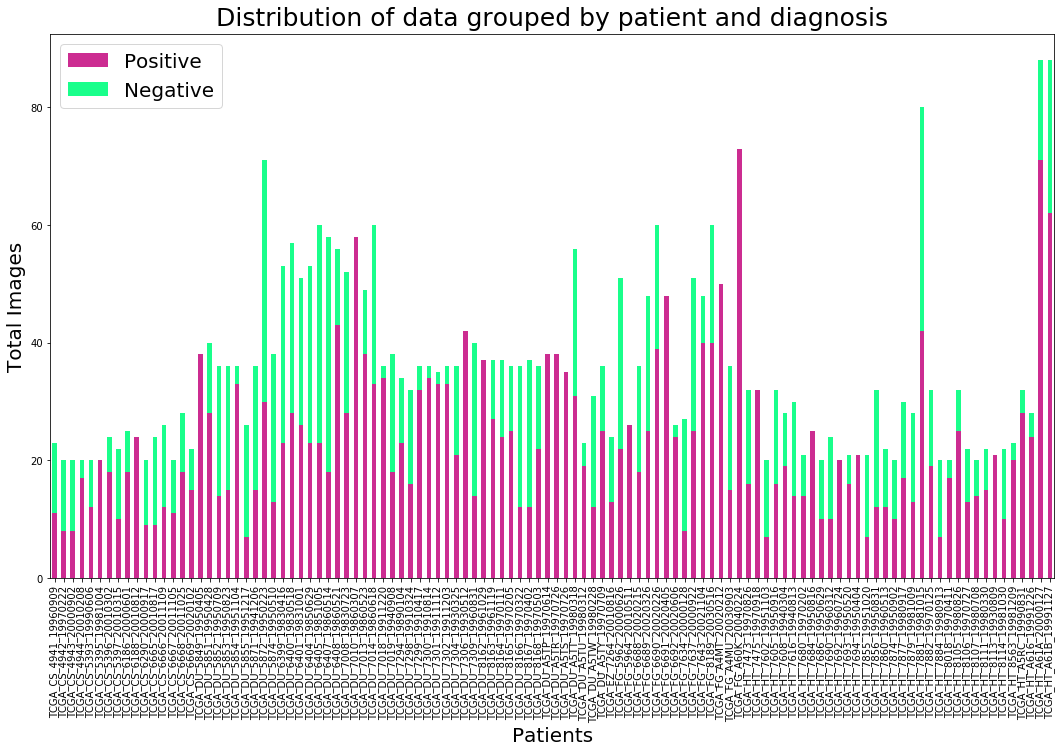

In [7]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

## Data Visualization

Samples of images with a positive and negative diagnosis

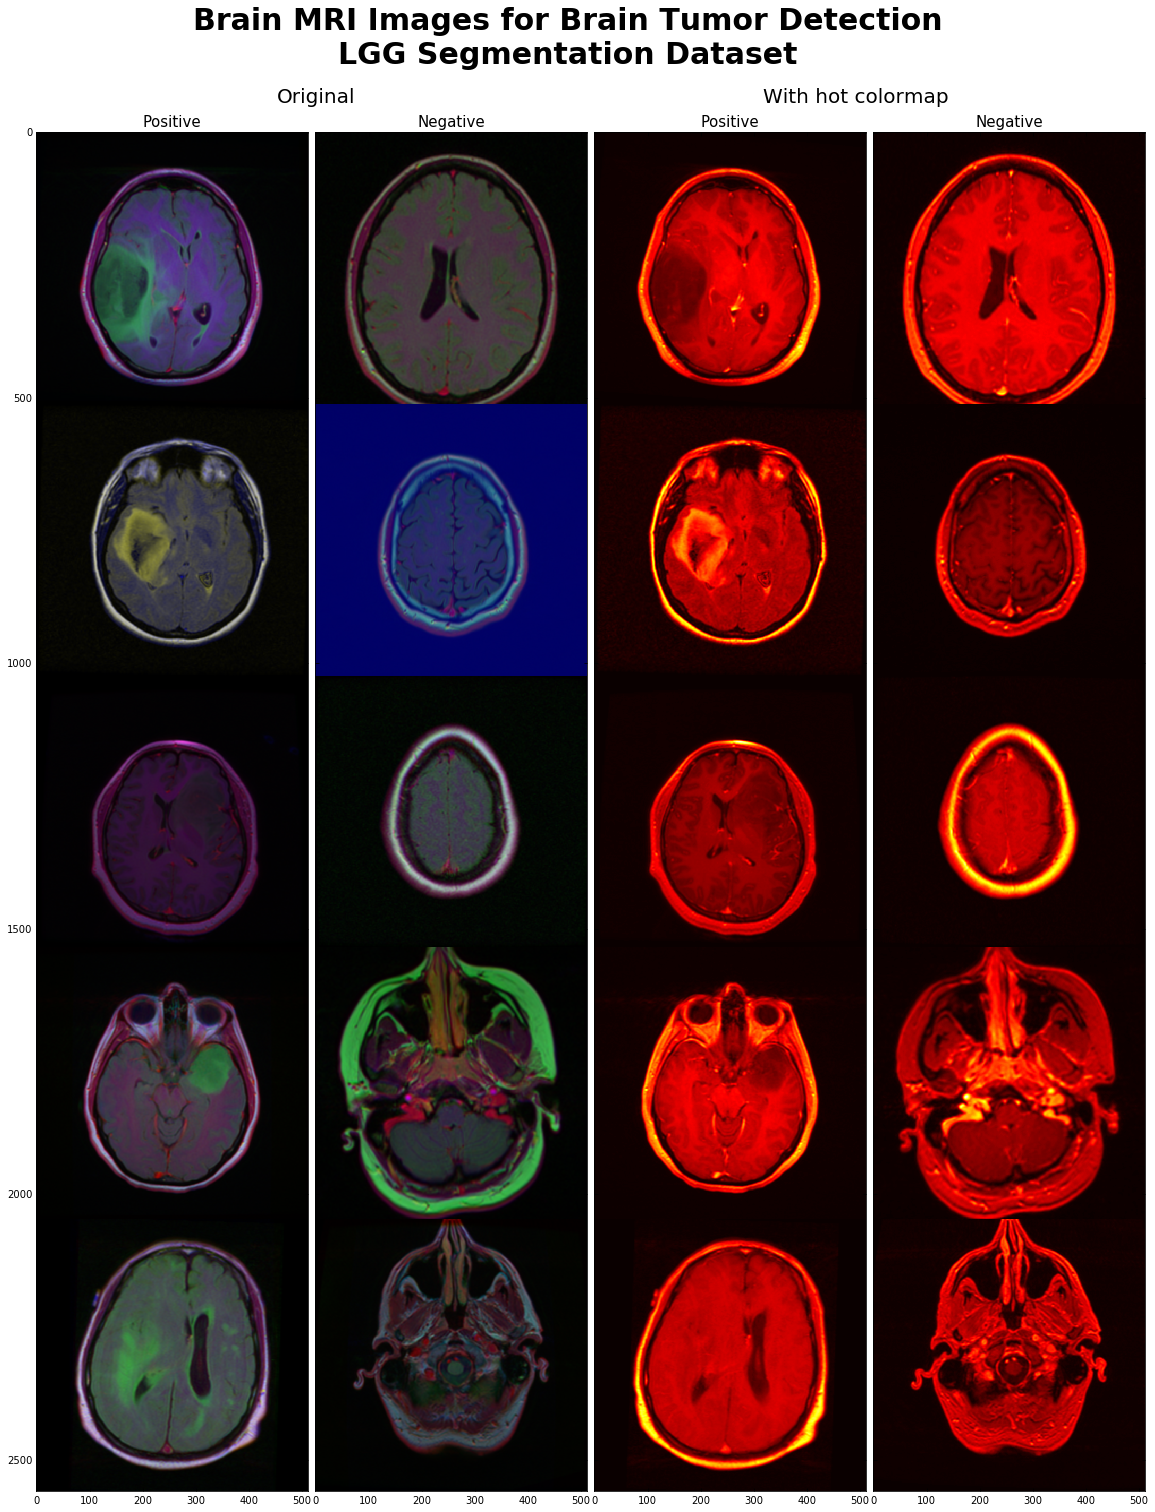

In [8]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

# Preprocess Dataset

In [1]:
import os
from random import shuffle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2

%matplotlib inline

In [18]:
def get_bbox(mask):
    """
    get bbox information from mask image
    mask: np.array, shape=(H, W)
    return: YOLO format x_center y_center width height"""
    W, H = mask.shape
    coords = cv2.findNonZero(mask)  # non-zero pos
    x, y, w, h = cv2.boundingRect(coords) # x,y - top-left
    # get the center of the bbox
    x_center = x + w / 2    
    y_center = y + h / 2
    # norm x_center, y_center
    x_center /= W
    y_center /= H
    return x_center, y_center, w/W, h/H
    

def convert2YOLO(files, mode, images_dir=r"./datasets/images", labels_dir=r"./datasets/labels"):
    """
    save image to images_dir and label to labels_dir
    files: list, file names
    mode: str, "train", "val", "test"
    """
    os.makedirs(images_dir, exist_ok=True)  # images
    images_dir = os.path.join(images_dir, mode)
    if len(os.listdir(images_dir)) > 0:
        print("assuming dataset has been splited...")
        return
    os.makedirs(images_dir, exist_ok=True)  # images/mode
    # labels
    os.makedirs(labels_dir, exist_ok=True)
    labels_dir = os.path.join(labels_dir, mode)
    os.makedirs(labels_dir, exist_ok=True)
    
    for file in files:
        img_path = file + ".tif"
        mask_path = file + "_mask.tif"
        # original image name
        name = os.path.splitext(os.path.basename(file))[0]
        img_name = name + ".jpg"
        label_name = name + ".txt"
        # save path
        img_save_path = os.path.join(images_dir, img_name)
        label_save_path = os.path.join(labels_dir, label_name)
        # read image and mask
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # save image in jpg format
        cv2.imwrite(img_save_path, img)
        
        # save label
        if mask.sum() == 0: # no target, skip
            continue
        # get bbox
        x, y,w,h = get_bbox(mask)
        with open(label_save_path, "w") as f:
            f.write(f"0 {x} {y} {w} {h}")

## Split Dataset

In [19]:
## split dataset

root = "kaggle_3m"
dirs = os.listdir(root)

file_paths = []
for dir in dirs:
    dir_name = os.path.join(root, dir)
    if os.path.isdir(dir_name):
        files = os.listdir(dir_name)
        # all tif files 
        for file in files:
            if file.endswith("mask.tif"):
                name = os.path.splitext(file)[0][:-5]
                file_paths.append(os.path.join(dir_name, name))

# split into train, val, test 7:2:1
num = len(file_paths)
train_num = int(num * 0.7)
val_num = int(num * 0.2)
test_num = num - train_num - val_num
# shuffle dataset
shuffle(file_paths)
train_files = file_paths[:train_num]
val_files = file_paths[train_num:train_num + val_num]
test_files = file_paths[train_num + val_num:]
# convert to YOLO format
convert2YOLO(train_files, "train")
convert2YOLO(val_files, "val")
convert2YOLO(test_files, "test")

assuming dataset has been splited...
assuming dataset has been splited...
assuming dataset has been splited...


# Train using pretrained yolov8s

In [2]:
## use pretrained yolov8s to fit the dataset
from ultralytics import YOLO

# create a yolov8 detection model
model = YOLO("yolov8s.pt")

results = model.train(
    data="data.yaml",
    epochs=20,
    batch=64,
    imgsz=256,
    device=0,
    project="yolo_log",
    name="train",
)

train: Scanning /data/xiyang/homework/datasets/labels/train.cache... 951 images, 1799 backgrounds, 0 corrupt: 100%|██████████| 2750/2750 [00:00<?, ?it/s]
val: Scanning /data/xiyang/homework/datasets/labels/val.cache... 280 images, 505 backgrounds, 0 corrupt: 100%|██████████| 785/785 [00:00<?, ?it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.62G      1.644       3.23      1.422         34        256: 100%|██████████| 43/43 [00:09<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        785        280      0.222      0.471      0.163     0.0981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.68G      1.535      1.319      1.308         36        256: 100%|██████████| 43/43 [00:08<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.15it/s]


                   all        785        280      0.427      0.604      0.527      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.65G      1.524      1.278      1.315         38        256: 100%|██████████| 43/43 [00:09<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]


                   all        785        280   0.000913      0.132   0.000417   7.99e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.69G       1.55      1.233      1.332         36        256: 100%|██████████| 43/43 [00:09<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


                   all        785        280    0.00329      0.382    0.00251    0.00118

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.69G      1.439      1.142      1.274         31        256: 100%|██████████| 43/43 [00:08<00:00,  5.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]

                   all        785        280       0.56      0.667       0.62      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.69G      1.399      1.036      1.271         47        256: 100%|██████████| 43/43 [00:08<00:00,  5.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]

                   all        785        280      0.586      0.386       0.43      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.69G      1.405     0.9981      1.263         39        256: 100%|██████████| 43/43 [00:08<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


                   all        785        280      0.815      0.743      0.804      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.68G      1.318     0.9333       1.22         36        256: 100%|██████████| 43/43 [00:08<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        785        280      0.896      0.764      0.868      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.68G      1.307     0.8886      1.213         36        256: 100%|██████████| 43/43 [00:08<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.23it/s]

                   all        785        280       0.85      0.796      0.864      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.68G      1.259      0.846      1.196         28        256: 100%|██████████| 43/43 [00:08<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        785        280      0.861      0.861      0.885      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.69G      1.222     0.8447      1.163         20        256: 100%|██████████| 43/43 [00:08<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]

                   all        785        280      0.889      0.782      0.865      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.68G      1.168     0.7767      1.135         21        256: 100%|██████████| 43/43 [00:08<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


                   all        785        280       0.88      0.787      0.878      0.582

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.69G      1.104     0.7299       1.12         17        256: 100%|██████████| 43/43 [00:08<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        785        280      0.905      0.848       0.91       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.69G      1.088     0.6958      1.112         26        256: 100%|██████████| 43/43 [00:09<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.24it/s]


                   all        785        280      0.902      0.821      0.892      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.69G      1.082     0.6628      1.102         23        256: 100%|██████████| 43/43 [00:08<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]

                   all        785        280      0.891      0.825      0.898      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.69G      1.045     0.6196      1.076         22        256: 100%|██████████| 43/43 [00:08<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]

                   all        785        280       0.91      0.864       0.92      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.69G     0.9856     0.5943      1.056         22        256: 100%|██████████| 43/43 [00:08<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]

                   all        785        280      0.926      0.868      0.924      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.65G     0.9535     0.5756      1.047         17        256: 100%|██████████| 43/43 [00:08<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]

                   all        785        280      0.921      0.857      0.926       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.69G     0.9382      0.539      1.024         26        256: 100%|██████████| 43/43 [00:08<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.42it/s]

                   all        785        280      0.943      0.871      0.939      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.69G     0.9304     0.5324      1.034         26        256: 100%|██████████| 43/43 [00:08<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]

                   all        785        280      0.929      0.893      0.939      0.694



Validating yolo_log/train/weights/best.pt...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.12it/s]


                   all        785        280      0.944      0.871      0.939      0.695


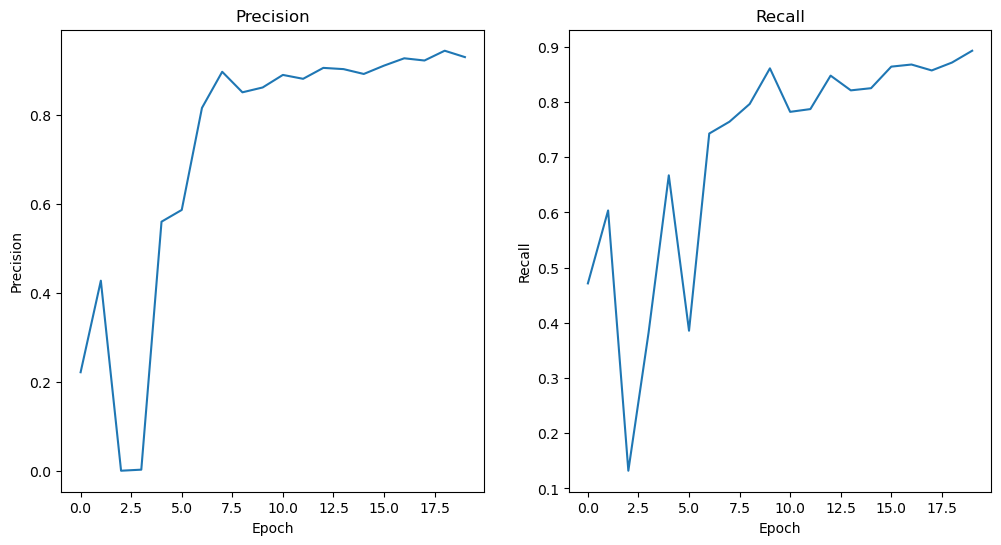

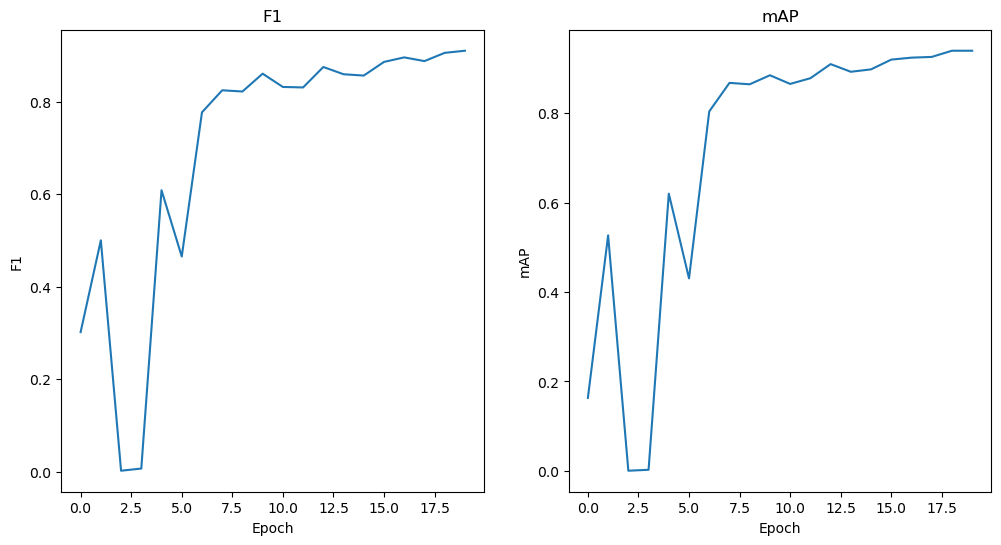

In [21]:
## plot validation metrics

def plot_show(metric1, metric2, name1, name2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(metric1)
    plt.title(name1)
    plt.xlabel("Epoch")
    plt.ylabel(name1)
    plt.subplot(1, 2, 2)
    plt.plot(metric2)
    plt.title(name2)
    plt.xlabel("Epoch")
    plt.ylabel(name2)
    plt.show()

record = pd.read_csv("yolo_log/train/results.csv")
# P curve, R curve
plot_show(record["metrics/precision(B)"], record["metrics/recall(B)"], "Precision", "Recall")
# F1 and mAP curve
F1 = 2 * record["metrics/precision(B)"] * record["metrics/recall(B)"] / (record["metrics/precision(B)"] + record["metrics/recall(B)"])
plot_show(F1, record["metrics/mAP50(B)"], "F1", "mAP")

In [3]:
## adjust parameters and apply data augmentation

model_t = YOLO("yolov8s.pt")
results = model_t.train(
    data="tune.yaml",   # add more data augmentation process
    epochs=20,
    batch=32,   # adjust batch size
    imgsz=256,
    device=0,
    project="yolo_log",
    name="tune",
    # cos_lr=True,  # use cosine lr scheduler
)

model_t.save("LGG_best.pt")

train: Scanning /data/xiyang/homework/datasets/labels/train.cache... 951 images, 1799 backgrounds, 0 corrupt: 100%|██████████| 2750/2750 [00:00<?, ?it/s]
val: Scanning /data/xiyang/homework/datasets/labels/val.cache... 280 images, 505 backgrounds, 0 corrupt: 100%|██████████| 785/785 [00:00<?, ?it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.52G       1.59      2.423      1.387         20        256: 100%|██████████| 86/86 [00:12<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]

                   all        785        280      0.278        0.4      0.353      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.62G      1.549      1.347      1.336         17        256: 100%|██████████| 86/86 [00:11<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.17it/s]

                   all        785        280       0.81      0.639      0.706      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.59G      1.475      1.237      1.308         18        256: 100%|██████████| 86/86 [00:10<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]

                   all        785        280      0.672      0.518      0.531      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       1.6G      1.533      1.206       1.34         19        256: 100%|██████████| 86/86 [00:11<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]

                   all        785        280      0.769      0.643       0.69      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.59G      1.454      1.118      1.294         17        256: 100%|██████████| 86/86 [00:11<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]

                   all        785        280      0.806      0.761      0.803      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.64G      1.383      1.053      1.265         25        256: 100%|██████████| 86/86 [00:10<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.93it/s]

                   all        785        280      0.783      0.675      0.753      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.59G      1.377      1.034      1.257         14        256: 100%|██████████| 86/86 [00:11<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.89it/s]

                   all        785        280      0.792      0.782      0.832      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.59G      1.275     0.9485      1.193         14        256: 100%|██████████| 86/86 [00:10<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]

                   all        785        280      0.872      0.768      0.856      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.59G      1.238     0.8867      1.179         18        256: 100%|██████████| 86/86 [00:10<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  9.56it/s]

                   all        785        280      0.853      0.685      0.808      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       1.6G      1.241     0.8797      1.194         18        256: 100%|██████████| 86/86 [00:07<00:00, 11.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.74it/s]

                   all        785        280      0.861      0.832      0.864      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.59G      1.161     0.8389       1.14          9        256: 100%|██████████| 86/86 [00:08<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.28it/s]

                   all        785        280      0.868      0.854      0.899      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.64G      1.167     0.8077      1.161         10        256: 100%|██████████| 86/86 [00:08<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.80it/s]

                   all        785        280       0.89      0.832      0.892      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.59G       1.13     0.7354      1.149         12        256: 100%|██████████| 86/86 [00:08<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.18it/s]

                   all        785        280      0.935      0.832      0.899       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       1.6G      1.083     0.7183      1.129         15        256: 100%|██████████| 86/86 [00:09<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]

                   all        785        280      0.913       0.85      0.913      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.65G      1.067     0.6927      1.103         10        256: 100%|██████████| 86/86 [00:08<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.48it/s]

                   all        785        280       0.91      0.871      0.929      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.64G      1.037     0.6392       1.08         10        256: 100%|██████████| 86/86 [00:08<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  7.75it/s]

                   all        785        280       0.92      0.854      0.922      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       1.6G     0.9964     0.6115      1.058         12        256: 100%|██████████| 86/86 [00:11<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]

                   all        785        280      0.892      0.886       0.93      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.59G     0.9713      0.589      1.063          7        256: 100%|██████████| 86/86 [00:10<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.77it/s]

                   all        785        280      0.906      0.882      0.931      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.6G      0.961     0.5484      1.049         10        256: 100%|██████████| 86/86 [00:10<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.90it/s]

                   all        785        280      0.932      0.893      0.937      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       1.6G     0.9485     0.5253      1.046         11        256: 100%|██████████| 86/86 [00:10<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]

                   all        785        280       0.93      0.893      0.943      0.699



Validating yolo_log/tune/weights/best.pt...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.35it/s]


                   all        785        280      0.931      0.893      0.943        0.7


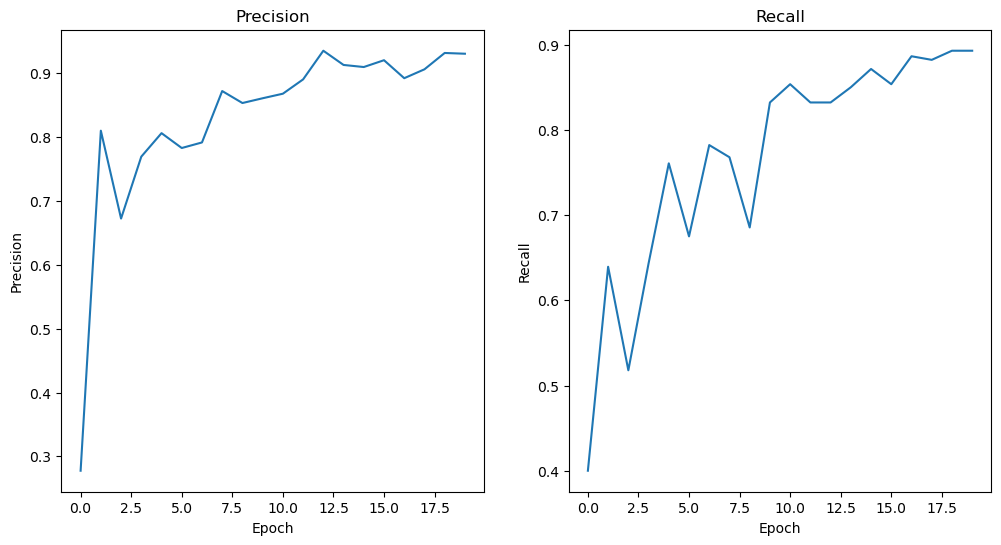

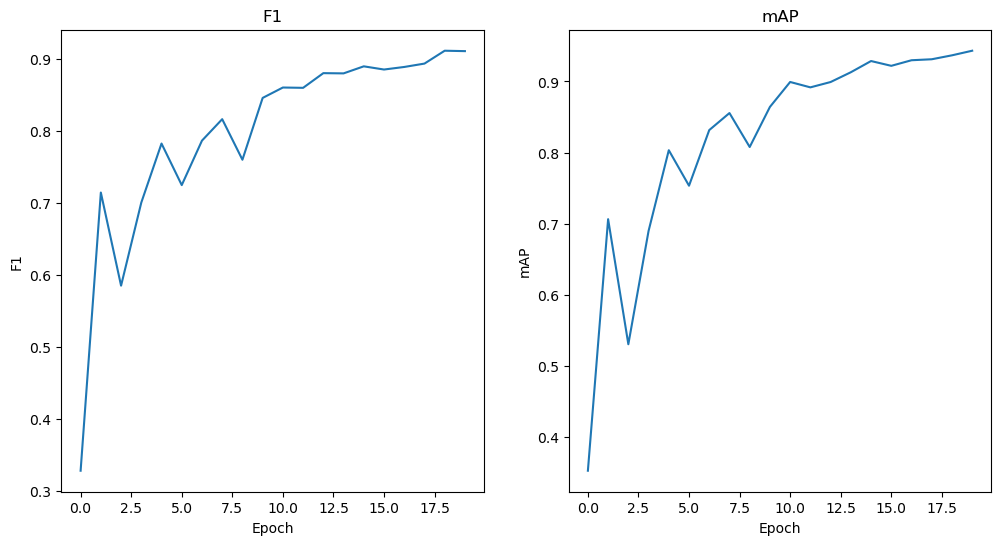

In [23]:
## plot validation metrics

def plot_show(metric1, metric2, name1, name2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(metric1)
    plt.title(name1)
    plt.xlabel("Epoch")
    plt.ylabel(name1)
    plt.subplot(1, 2, 2)
    plt.plot(metric2)
    plt.title(name2)
    plt.xlabel("Epoch")
    plt.ylabel(name2)
    plt.show()

record = pd.read_csv("yolo_log/tune/results.csv")
# P curve, R curve
plot_show(record["metrics/precision(B)"], record["metrics/recall(B)"], "Precision", "Recall")
# F1 and mAP curve
F1 = 2 * record["metrics/precision(B)"] * record["metrics/recall(B)"] / (record["metrics/precision(B)"] + record["metrics/recall(B)"])
plot_show(F1, record["metrics/mAP50(B)"], "F1", "mAP")

# Testing

In [4]:
## quantitative results
metrics = model_t.val(split="test", imgsz=256, conf=0.3, iou=0.6, max_det=1)

print(f"mAP@0.5: {metrics.box.map50}")

val: Scanning /data/xiyang/homework/datasets/labels/test.cache... 142 images, 252 backgrounds, 0 corrupt: 100%|██████████| 394/394 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


                   all        394        142       0.95      0.931      0.961      0.743
mAP@0.5: 0.9609698594936337


In [5]:
## qualitative results
test_path = r"datasets/images/test/"
results = model_t.predict(test_path, imgsz=256, device=3, stream=True, conf=0.3, iou=0.6, max_det=1
                        )
FP = []
img_show = []

for result in results:
    FP_flag = False
    img_path = result.path
    basename = os.path.basename(img_path)

    im_bgr = result.plot()  # BGR-order numpy array
    W, H = im_bgr.shape[1], im_bgr.shape[0]
    
    boxes = result.boxes.cpu().numpy()
    
    # load gt labels
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
    if os.path.isfile(label_path):
        with open(label_path, "r") as f:
            for line in f:
                line = line.strip().split()
                x, y, w, h = map(float, line[1:])
                x1, y1, x2, y2 = int((x-w/2)*W), int((y-h/2)*H), int((x+w/2)*W), int((y+h/2)*H)
                cv2.rectangle(im_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
                # put GT text on the image right bottom of the bbox
                text_x = x2
                text_y = y2+20
                cv2.putText(im_bgr, "GT", (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    elif boxes.shape[0]>0:
        FP.append(basename)
        
    cv2.imwrite(f"results/{basename}", im_bgr)   
    
    if boxes.shape[0]>0 and len(img_show)<3:
        img_show.append(basename)

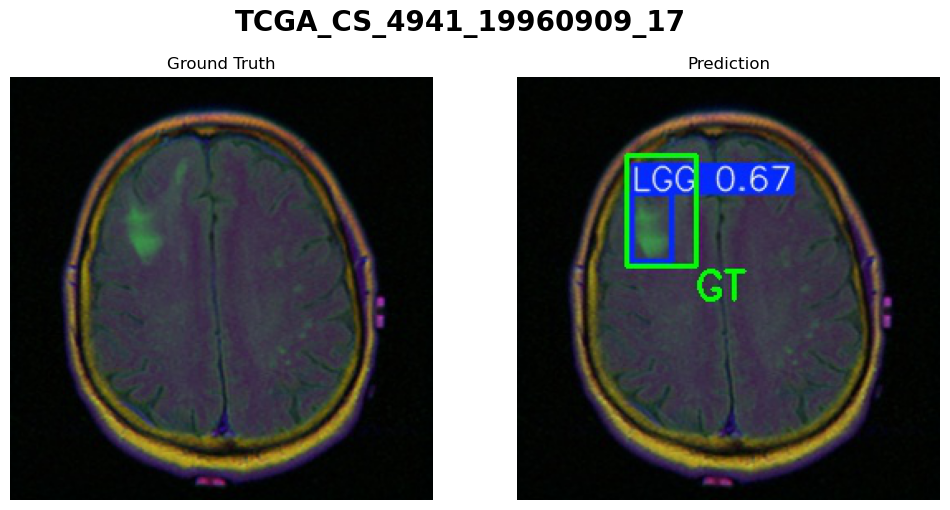

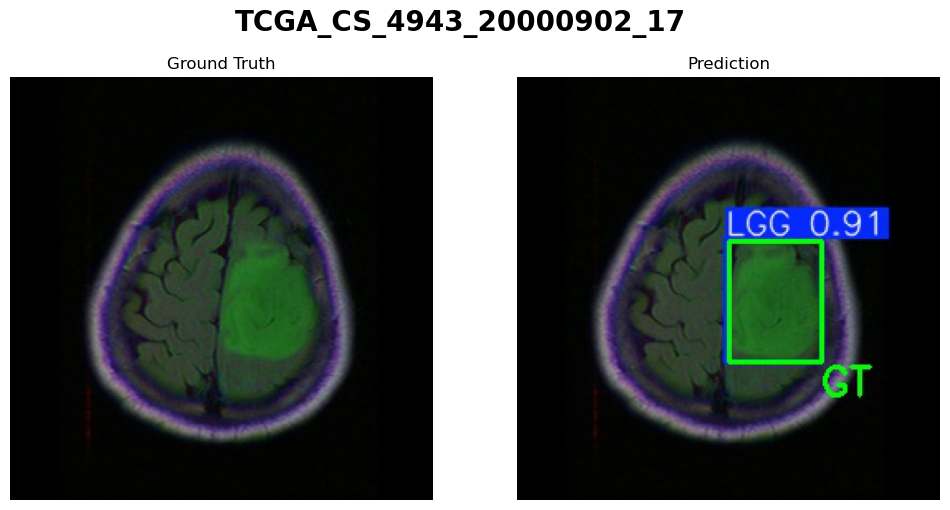

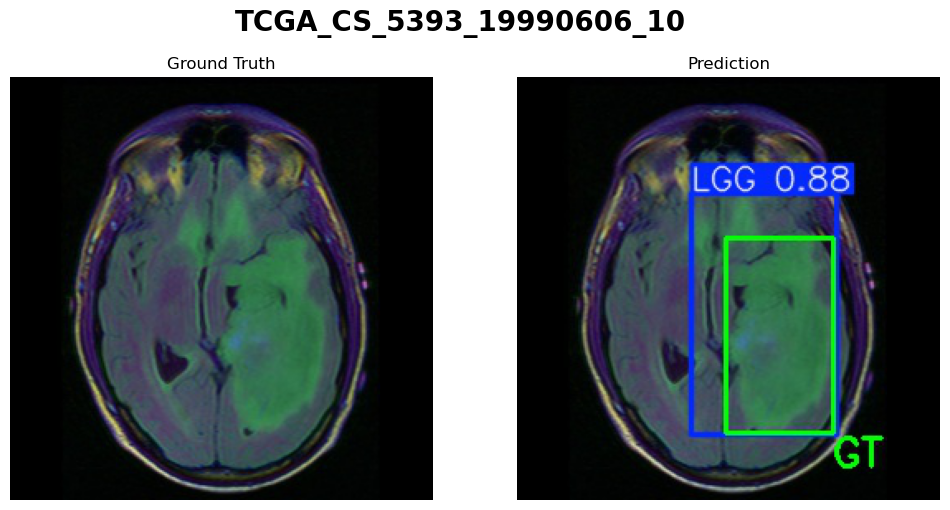

In [26]:
from PIL import Image

def show_imgs(img_path1, img_path2):
    basename = os.path.basename(img_path1)
    name = os.path.splitext(basename)[0]
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(img_path1))
    plt.title("Ground Truth")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(Image.open(img_path2))
    plt.title("Prediction")
    plt.axis("off")
    plt.suptitle(name, y=.96, fontsize=20, weight="bold")
    plt.show()
    
for img in img_show:
    show_imgs(f"{test_path}/{img}", f"results/{img}")

## Failure cases
FP detection

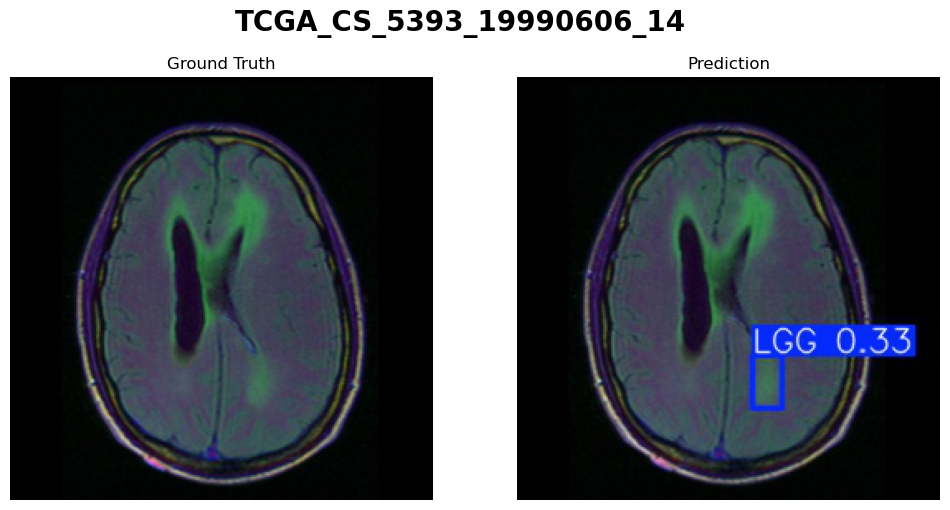

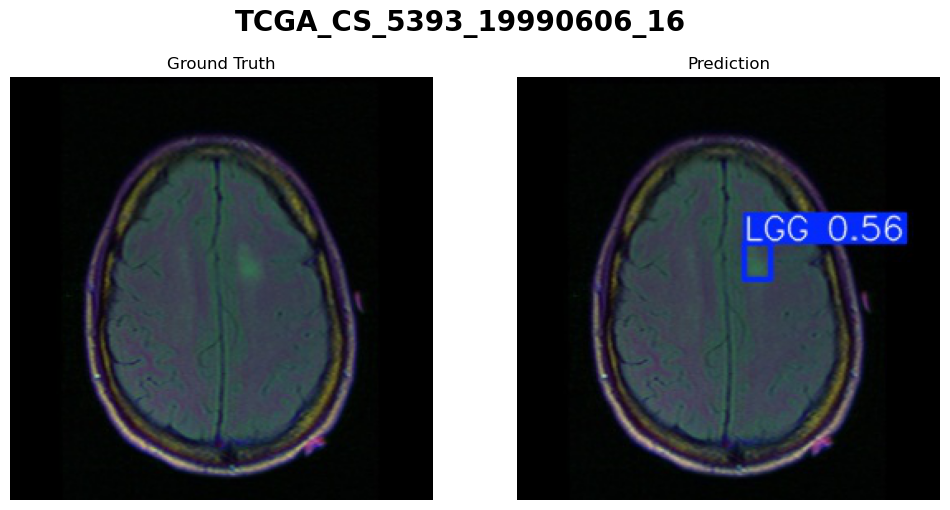

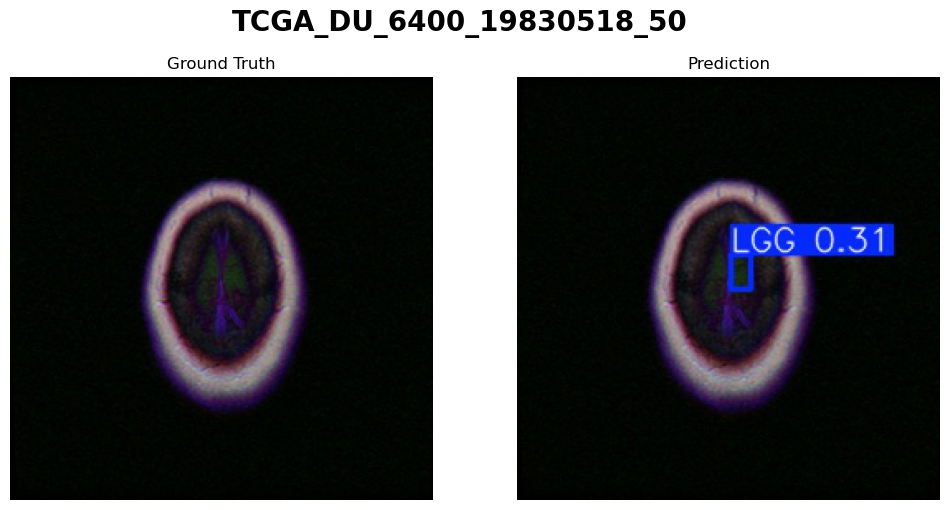

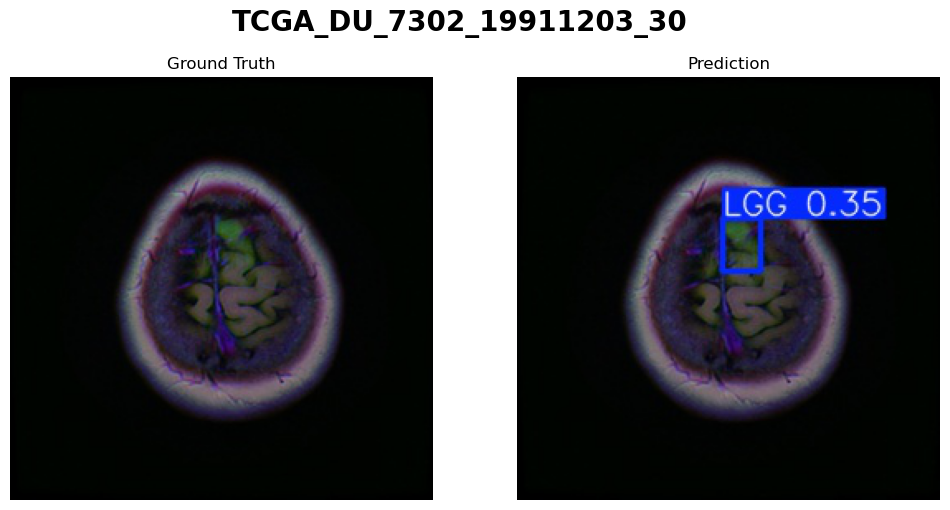

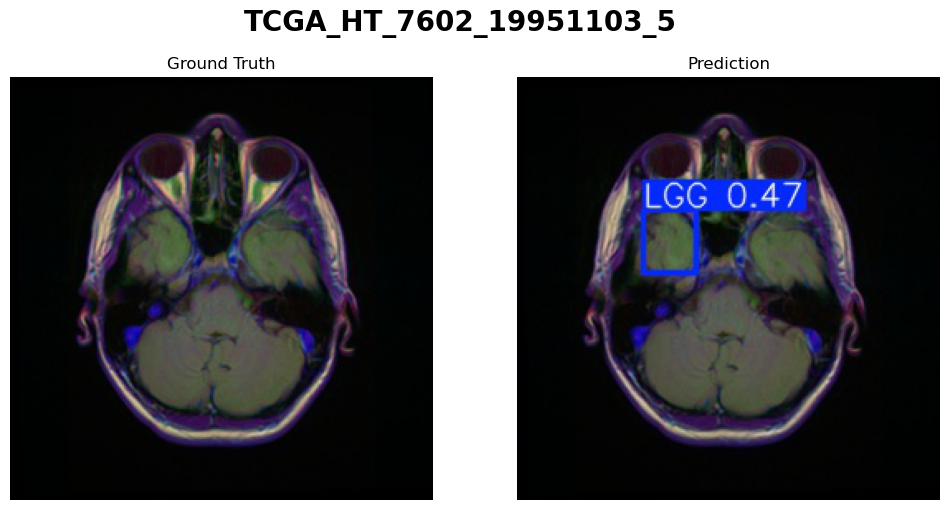

In [27]:
# show false positive cases   
for fp in FP:
    img_path1 = os.path.join(test_path, fp)
    img_path2 = os.path.join("results", fp)
    show_imgs(img_path1, img_path2)